In [50]:
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import numpy as np
import pandas as pd
import random

SHOW_PLOTS = True

In [51]:
def run_dbscan_on_buildings(gdf_buildings, eps_m=400, min_samples=10, N_LARGEST=3):
    """
    Run DBSCAN on gdf_buildings (already in EPSG:2263), 
    pick top N_LARGEST clusters by size, compute centroids.
    
    Returns:
      gdf_buildings (modified with new columns):
        - 'bldg_cluster': DBSCAN integer labels
      cluster_centroids: list of (cluster_label, (cx, cy))
      top_clusters: array of the top N_LARGEST labels
    """
    # Create 'centroid' column if not present
    if "centroid" not in gdf_buildings.columns:
        gdf_buildings["centroid"] = gdf_buildings.geometry.centroid
    
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    
    # DBSCAN
    db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords_bldg)
    labels_bldg = db.labels_
    gdf_buildings["bldg_cluster"] = labels_bldg
    
    # Identify valid clusters (ignore noise = -1)
    valid_mask = (labels_bldg >= 0)
    unique_labels, counts = np.unique(labels_bldg[valid_mask], return_counts=True)
    
    # Sort cluster labels by descending size
    sorted_idx = np.argsort(-counts)  # negative for descending
    sorted_labels = unique_labels[sorted_idx]  # e.g. [0,2,1,3,4,...]
    sorted_counts = counts[sorted_idx]
    
    # pick top N_LARGEST
    top_clusters = sorted_labels[:N_LARGEST]
    
    # compute centroids for top clusters
    cluster_centroids = []
    for clabel in top_clusters:
        cl_mask = (gdf_buildings["bldg_cluster"] == clabel)
        cluster_coords = coords_bldg[cl_mask]
        if len(cluster_coords) > 0:
            mp = MultiPoint(cluster_coords)
            c_centroid = mp.centroid
            cluster_centroids.append((clabel, (c_centroid.x, c_centroid.y)))
    
    return gdf_buildings, cluster_centroids, top_clusters

In [52]:
print("Loading building footprints...")
gdf_buildings = gpd.read_file("./data/Building_Footprint_SF.kml").to_crs("EPSG:2263")
print("Done loading geospatial data.")

Loading building footprints...
Done loading geospatial data.


In [53]:
# print("Loading Training CSV ...")
# df_train = pd.read_csv("./data/Training_data_uhi_index_UHI2025-v2.csv")
# print("df_train shape:", df_train.shape)

# gdf_train = gpd.GeoDataFrame(
#     df_train,
#     geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
#     crs="EPSG:4326"
# ).to_crs("EPSG:2263")

In [54]:
# import geopandas as gpd
# from shapely.geometry import box

# # 1. Extract the total bounds of gdf_train
# minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# # 2. Define a buffer in the same units as your CRS (here, meters)
# buffer = 1000  # adjust this value if you need a slightly larger or smaller margin

# # 3. Create an expanded bounding box
# expanded_bbox = box(minx_train - buffer, 
#                     miny_train - buffer, 
#                     maxx_train + buffer, 
#                     maxy_train + buffer)

# # Optional: If you want to see the coordinates of the expanded bounding box:
# print("Expanded Bounding Box:", expanded_bbox.bounds)

# # 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
# gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
# gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# # Check the total bounds of the new subset
# print("Subset Total Bounds:", gdf_buildings.total_bounds)
# print("Train Total Bounds:", gdf_train.total_bounds)

In [87]:
# 1) Run DBSCAN
N_LARGEST = 10
eps_m = 400
min_samples = 100
gdf_buildings, cluster_centroids, top_clusters = run_dbscan_on_buildings(
    gdf_buildings, 
    eps_m=eps_m,
    min_samples=min_samples,
    N_LARGEST=N_LARGEST
)

print(f"Top {N_LARGEST} clusters by building count: {top_clusters}")
print("Cluster centroids for top N largest clusters:")
for (lbl, (cx, cy)) in cluster_centroids:
    print(f"  Cluster {lbl} => centroid=({cx:.2f}, {cy:.2f})")

Top 10 clusters by building count: [ 2  0  1  3  6 10  8  7  4  5]
Cluster centroids for top N largest clusters:
  Cluster 2 => centroid=(-12335106.79, 2898504.74)
  Cluster 0 => centroid=(-12340908.89, 2887878.59)
  Cluster 1 => centroid=(-12347007.64, 2906280.14)
  Cluster 3 => centroid=(-12344450.95, 2915901.82)
  Cluster 6 => centroid=(-12353004.91, 2908922.26)
  Cluster 10 => centroid=(-12348693.13, 2893082.40)
  Cluster 8 => centroid=(-12329449.57, 2887052.62)
  Cluster 7 => centroid=(-12337505.05, 2912428.85)
  Cluster 4 => centroid=(-12321955.64, 2910664.72)
  Cluster 5 => centroid=(-12327500.03, 2914588.99)


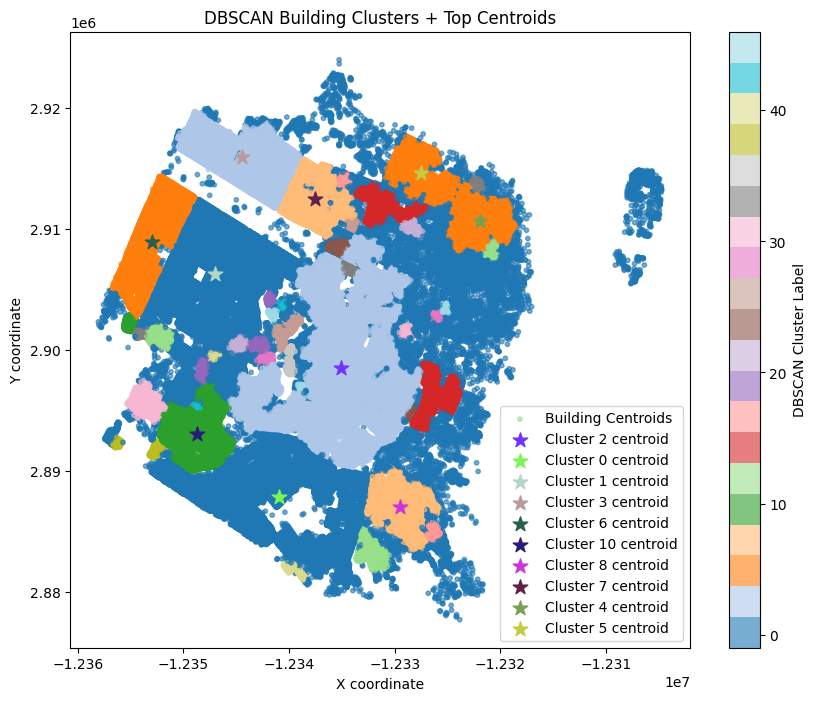

In [90]:
if SHOW_PLOTS:
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    labels_bldg = gdf_buildings["bldg_cluster"].values
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        coords_bldg[:, 0],
        coords_bldg[:, 1],
        c=labels_bldg,
        cmap='tab20',
        s=10,
        alpha=0.6,
        label="Building Centroids"
    )
    # Mark cluster centroids
    for (lbl, (cx, cy)) in cluster_centroids:
        random_color = mcolors.to_rgba((random.random(), random.random(), random.random()))
        ax.scatter(cx, cy, color=random_color, marker='*', s=120, label=f"Cluster {lbl} centroid")
    
    ax.set_title("DBSCAN Building Clusters + Top Centroids")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    cb = plt.colorbar(scatter, ax=ax, label="DBSCAN Cluster Label")
    
    # Deduplicate legend entries
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    
    plt.show()